In [1]:
import datetime
from enum import auto, Enum
import os
import pathlib
import sys

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

from lifelines import KaplanMeierFitter

from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import pairwise_logrank_test
from lifelines.utils import survival_events_from_table

from IPython.display import display, HTML

from mvt_survival import AlphaColor, create_p_value_legend_figure
from mvt_survival import get_corrected_p_values, create_stats_df, create_stats_df_with_corrected_p_values
from mvt_survival import create_proportion_and_stats_df
from mvt_survival import kmf_fit_group, get_stats_from_kmf
from mvt_survival import create_pairwise_plot, get_pairwise_comparisons_and_mosaic_layout
from mvt_survival import SaveDataFrames, concat_pdf_files, display_df

In [2]:
now = datetime.datetime.now()
todays_date = str(now.date())
print(f"Date: {now.strftime('%Y-%m-%d %H:%M')}")

print("Python version: %s\n" % sys.version)

pd.show_versions()

Date: 2023-03-10 15:54
Python version: 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:12:32) [MSC v.1929 64 bit (AMD64)]



C:\Users\mitullius\.conda\envs\py311-survival\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



INSTALLED VERSIONS
------------------
commit           : 2e218d10984e9919f0296931d92ea851c6a6faf5
python           : 3.11.0.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19044
machine          : AMD64
processor        : Intel64 Family 6 Model 165 Stepping 5, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : English_United States.1252

pandas           : 1.5.3
numpy            : 1.24.2
pytz             : 2022.7.1
dateutil         : 2.8.2
setuptools       : 67.5.1
pip              : 23.0.1
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 3.1.2
IPython          : 8.11.0
pandas_datareader: None
bs4              : 4.11.2
bottleneck       : None
brot

In [3]:
class ExperimentName(Enum):
    EXAMPLE = auto()
    Bp_m01 = auto()
    Bp_m02 = auto()
    Bp_m03A = auto()
    Bp_m03B = auto()
    Bp_m06_low = auto()
    Bp_m06_medium = auto()
    Bp_m06_high = auto()
    Bp_m09 = auto()

class Experiment:
    
    def __init__(self, name, input_directory, input_file_name):
        
        self.name = name
        self.input_directory = input_directory
        self.input_file_name = input_file_name


In [4]:
INPUT_DIRECTORY = r'C:\Users\mitullius\Notebook\2023\Bp vaccine paper\survival data'

experiments = {}

experiments[ExperimentName.EXAMPLE] = Experiment(ExperimentName.Bp_m01.name,
                                                './example',
                                                'EXAMPLE_survival.csv')
 
experiments[ExperimentName.Bp_m01] = Experiment(ExperimentName.Bp_m01.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m01_survival.csv')

experiments[ExperimentName.Bp_m02] = Experiment(ExperimentName.Bp_m02.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m02_survival.csv')

experiments[ExperimentName.Bp_m03A] = Experiment(ExperimentName.Bp_m03A.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m03A_survival.csv')

experiments[ExperimentName.Bp_m03B] = Experiment(ExperimentName.Bp_m03B.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m03B_survival.csv')

experiments[ExperimentName.Bp_m06_low] = Experiment(ExperimentName.Bp_m06_low.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m06_low_survival.csv')

experiments[ExperimentName.Bp_m06_medium] = Experiment(ExperimentName.Bp_m06_medium.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m06_medium_survival.csv')

experiments[ExperimentName.Bp_m06_high] = Experiment(ExperimentName.Bp_m06_high.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m06_high_survival.csv')

experiments[ExperimentName.Bp_m09] = Experiment(ExperimentName.Bp_m09.name,
                                                INPUT_DIRECTORY,
                                                'Bp_m09_survival.csv')


In [5]:
EXAMPLE = True

if EXAMPLE:
    exp = experiments[ExperimentName.EXAMPLE]
    input_path = pathlib.Path(exp.input_directory).absolute()
else:
    input_path = pathlib.Path(INPUT_DIRECTORY).absolute()


python_path = pathlib.Path(os.getcwd())
output_path = input_path / f'output {todays_date}'
output_path.mkdir(parents=True, exist_ok=True)

print('\n')
print(f'Python notebook directory:\t{python_path}')
print(f'Input directory:\t\t{input_path}')
print(f'Output directory:\t\t{output_path}')
print('\n')



Python notebook directory:	C:\Users\mitullius\Notebook\2023\Python\Bp-survival-analysis
Input directory:		C:\Users\mitullius\Notebook\2023\Python\Bp-survival-analysis\example
Output directory:		C:\Users\mitullius\Notebook\2023\Python\Bp-survival-analysis\example\output 2023-03-10




p_value_image_filename=WindowsPath('C:/Users/mitullius/Notebook/2023/Python/Bp-survival-analysis/example/output 2023-03-10/p-values.pdf')


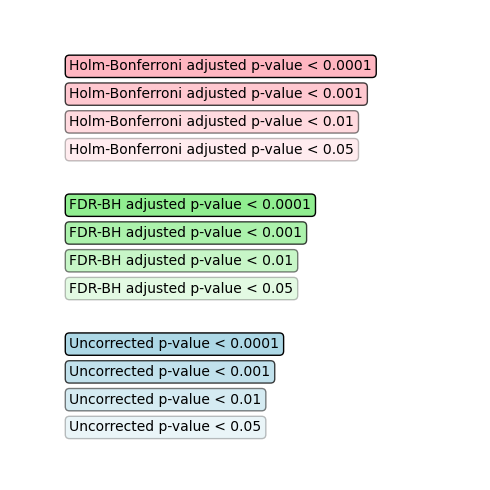

In [6]:
p_value_image_filename = output_path / 'p-values.pdf'
print(f'{p_value_image_filename=}')

holm_corrected_p_value_colors = {0.0001:('lightpink', 1),
                            0.001:('lightpink', 0.75),
                            0.01:('lightpink', 0.5),
                            0.05:('lightpink', 0.25)}

fdr_corrected_p_value_colors = {0.0001:('lightgreen', 1),
                            0.001:('lightgreen', 0.75),
                            0.01:('lightgreen', 0.5),
                            0.05:('lightgreen', 0.25)}

uncorrected_p_value_colors = {0.0001:('lightblue', 1),
                              0.001:('lightblue', 0.75),
                              0.01:('lightblue', 0.5),
                              0.05:('lightblue', 0.25)}

alpha_color = AlphaColor(holm_corrected_p_value_colors, fdr_corrected_p_value_colors, uncorrected_p_value_colors)

fig = create_p_value_legend_figure(['Holm-Bonferroni', 'FDR-BH'], alpha_color, p_value_image_filename)

# Analyze Survival Data from all Experiments

Saving DataFrame: raw data
Saving DataFrame: Describe
Saving DataFrame: Unique Values for Day
Saving DataFrame: Unique Values for Group
Saving DataFrame: Unique Values for Group_Name
Saving DataFrame: Unique Values for Mouse
Saving DataFrame: Unique Values for Death
Saving DataFrame: Unique Values for Survival_w...
Saving DataFrame: p-values
Saving DataFrame: survival fraction
Saving DataFrame: proportion_df
Saving DataFrame: survival_stats_df
Saving DataFrame: sterile_stats_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Group                           40 non-null     object
 1   Group_Name                      40 non-null     object
 2   Mouse                           40 non-null     object
 3   Day                             40 non-null     int64 
 4   Death                           40 non-null     int64 
 5   Survival_with_sterile_immunity  40 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 8.1 KB


,Group,Group_Name,Mouse,Day,Death,Survival_with_sterile_immunity
0,A,Group A,A1,3,1,0
1,A,Group A,A2,3,1,0
2,A,Group A,A3,3,1,0
3,A,Group A,A4,3,1,0
4,A,Group A,A5,3,1,0
5,A,Group A,A6,3,1,0
6,A,Group A,A7,3,1,0
7,A,Group A,A8,3,1,0
8,B,Group B,B1,42,0,0
9,B,Group B,B2,42,0,1


,Group,Group_Name,Mouse,Day,Death,Survival_with_sterile_immunity
count,40,40,40,40.000000,40.00000,40.000000
unique,5,5,40,NaN,NaN,NaN
top,A,Group A,A1,NaN,NaN,NaN
freq,8,8,1,NaN,NaN,NaN
mean,NaN,NaN,NaN,23.400000,0.50000,0.350000
std,NaN,NaN,NaN,19.235117,0.50637,0.483046
min,NaN,NaN,NaN,3.000000,0.00000,0.000000
25%,NaN,NaN,NaN,3.000000,0.00000,0.000000
50%,NaN,NaN,NaN,32.500000,0.50000,0.000000
75%,NaN,NaN,NaN,42.000000,1.00000,1.000000


,Day
0,3
1,19
2,23
3,42


,Group
0,A
1,B
2,C
3,D
4,E


,Group_Name
0,Group A
1,Group B
2,Group C
3,Group D
4,Group E


,Mouse
0,A1
1,A2
2,A3
3,A4
4,A5
5,A6
6,A7
7,A8
8,B1
9,B2


,Death
0,0
1,1


,Survival_with_sterile_immunity
0,0
1,1


,Group_1,Group_2,pair,uncorrected_p_value,p_value_fdr_bh,p_value_holm_bonferroni,p_value_holm_sidak,sig_uncorrected,sig_fdr_bh,sig_holm_bonferroni,sig_holm_sidak
index,,,,,,,,,,,
0,A,B,A-B,0.000636,0.001060,0.005090,0.005079,***,**,**,**
1,A,C,A-C,1.000000,1.000000,1.000000,1.000000,ns,ns,ns,ns
2,A,D,A-D,0.000108,0.000538,0.001075,0.001075,***,***,**,**
3,A,E,A-E,0.000636,0.001060,0.005090,0.005079,***,**,**,**
4,B,C,B-C,0.000636,0.001060,0.005090,0.005079,***,**,**,**
5,B,D,B-D,0.483160,0.690228,1.000000,0.928645,ns,ns,ns,ns
6,B,E,B-E,0.554772,0.693465,1.000000,0.928645,ns,ns,ns,ns
7,C,D,C-D,0.000108,0.000538,0.001075,0.001075,***,***,**,**
8,C,E,C-E,0.000636,0.001060,0.005090,0.005079,***,**,**,**


,lower_0.95,upper_0.95,final_survival,median_survival_time
Group,,,,
A,0.000000,0.000000,0.000,3.0
B,0.314807,0.930898,0.750,inf
C,0.000000,0.000000,0.000,3.0
D,0.387000,0.981393,0.875,inf
E,0.387000,0.981393,0.875,inf


,Group,Died,Survived,total_mice,Survival_with_sterile_immunity,not_sterile,percent_survival,percent_sterile
0,A,8,0,8,0,8,0.0,0.0
1,B,2,6,8,4,4,75.0,50.0
2,C,8,0,8,0,8,0.0,0.0
3,D,1,7,8,6,2,87.5,75.0
4,E,1,7,8,4,4,87.5,50.0


,Pair,uncorrected_p_value_barnard,p_value_barnard_fdr_bh,p_value_barnard_holm_bonferroni,p_value_barnard_holm_sidak,sig_barnard_uncorrected,sig_barnard_fdr_bh,sig_barnard_holm_bonferroni,sig_barnard_holm_sidak
index,,,,,,,,,
0,A-B,0.001892,0.003153,0.011353,0.011299,**,**,*,*
1,A-C,1.000000,1.000000,1.000000,1.000000,ns,ns,ns,ns
2,A-D,0.000305,0.000763,0.003052,0.003048,***,***,**,**
3,A-E,0.000305,0.000763,0.003052,0.003048,***,***,**,**
4,B-C,0.001892,0.003153,0.011353,0.011299,**,**,*,*
5,B-D,0.691029,0.863786,1.000000,0.990887,ns,ns,ns,ns
6,B-E,0.691029,0.863786,1.000000,0.990887,ns,ns,ns,ns
7,C-D,0.000305,0.000763,0.003052,0.003048,***,***,**,**
8,C-E,0.000305,0.000763,0.003052,0.003048,***,***,**,**


,Pair,uncorrected_p_value_barnard,p_value_barnard_fdr_bh,p_value_barnard_holm_bonferroni,p_value_barnard_holm_sidak,sig_barnard_uncorrected,sig_barnard_fdr_bh,sig_barnard_holm_bonferroni,sig_barnard_holm_sidak
index,,,,,,,,,
0,A-B,0.026001,0.043335,0.182007,0.168409,*,*,ns,ns
1,A-C,1.000000,1.000000,1.000000,1.000000,ns,ns,ns,ns
2,A-D,0.001892,0.009460,0.018921,0.018761,**,**,*,*
3,A-E,0.026001,0.043335,0.182007,0.168409,*,*,ns,ns
4,B-C,0.019616,0.043335,0.156929,0.146568,*,*,ns,ns
5,B-D,0.391784,0.489729,1.000000,0.862813,ns,ns,ns,ns
6,B-E,1.000000,1.000000,1.000000,1.000000,ns,ns,ns,ns
7,C-D,0.001892,0.009460,0.018921,0.018761,**,**,*,*
8,C-E,0.026001,0.043335,0.182007,0.168409,*,*,ns,ns


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          32.08 <0.005     19.05

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic      p  -log2(p)
A B           11.67 <0.005     10.62
  C            0.00   1.00     -0.00
  D           15.00 <0.005     13.18
  E           11.67 <0.005     10.62
B C           11.67 <0.005     10.62
  D            0.49   0.48      1.05
  E            0.35   0.55      0.85
C D           15.00 <0.005     13.18
  E           11.67 <0.005     10.62
D E            0.00   0.96      0.06

{'A': <lifelines.KaplanMeierFitter:"A", fitted with 8 total observations, 0 right-censored observations>,
 'B': <lifelines.KaplanMeierFitter:"B", fitted with 8 total observations, 6 right-censored observations>,
 'C': <lifelines.KaplanMeierFitter:"C", fitted with 8 total observations, 0 right-censored observations>,
 'D': <lifelines.KaplanMeierFitter:"D", fitted with 8 total observations, 7 right-censored observations>,
 'E': <lifelines.KaplanMeierFitter:"E", fitted with 8 total observations, 7 right-censored observations>}

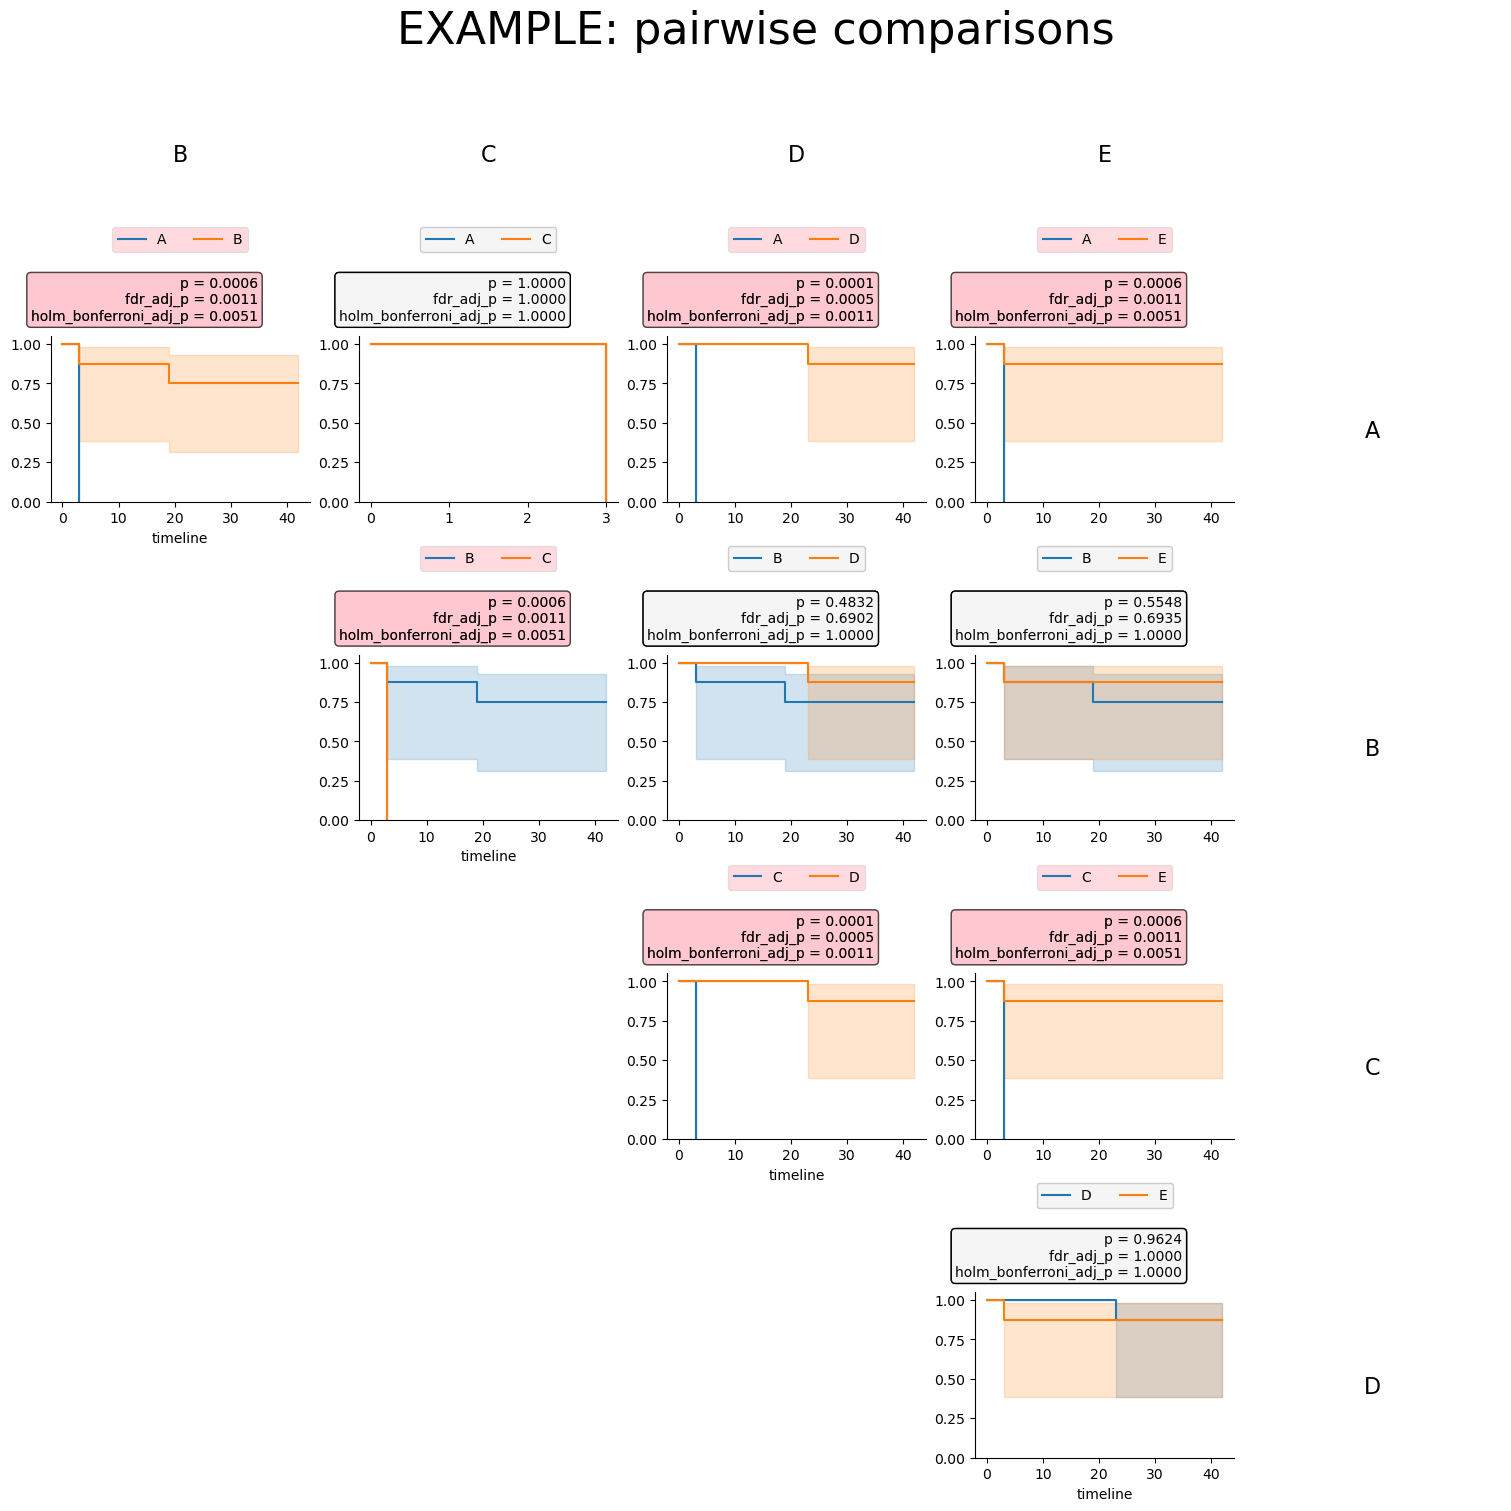

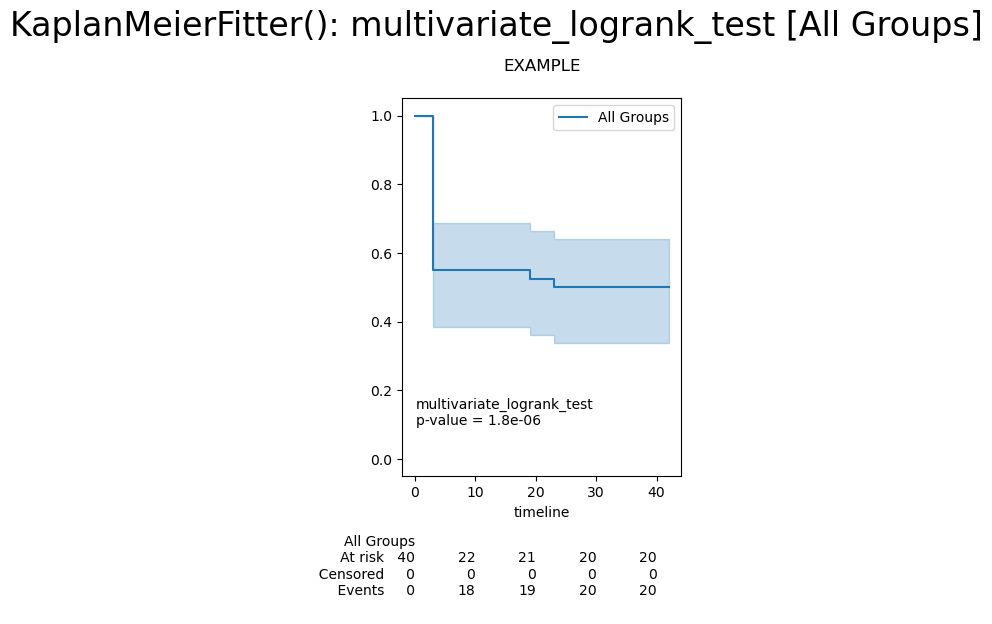

{'EXAMPLE': <lifelines.KaplanMeierFitter:"All Groups", fitted with 40 total observations, 20 right-censored observations>}

In [7]:
all_raw_dataframes = {}
kmf_fit_all = {}
multivariate_logrank_test_results = {}
pairwise_logrank_test_results = {}
pairwise_comparisons = {}
mosaic_layouts = {}

if EXAMPLE:
    exp_items = [(ExperimentName.EXAMPLE, experiments[ExperimentName.EXAMPLE])]
else:
    exp_items = [item for item in experiments.items() if item[0].name != 'EXAMPLE']

for exp_name, exp in exp_items:
    
    output_pdf_files = [p_value_image_filename]
           
    output_file = f'{exp_name.name} survival {todays_date}.xlsx'
    save_dataframes = SaveDataFrames(output_path / output_file)
    
    display(HTML('<br><h1>________________________________________________________________________________</h1>'))
    display(HTML(f'<h1>{exp_name.name}</h1><br>'))
    display(HTML(f'<h3>{output_file=}</h3><br>'))
    
    # Read raw survival data and store in a dictionary accessible by experiment name.
    raw_data_df = pd.read_csv(pathlib.Path(exp.input_directory) / exp.input_file_name)
    all_raw_dataframes[exp_name.name] = raw_data_df
    
    
    # Perform Kaplan Meier Survival Analysis using the lifelines package. Perform multivariate and pairwise logrank tests on the data.
    # Store the results in dictionaries accessible by experiment name.
    
    kmf_fit_all[exp_name.name] = KaplanMeierFitter().fit(raw_data_df["Day"], raw_data_df["Death"], label='All Groups')
    multivariate_logrank_test_results[exp_name.name] = multivariate_logrank_test(raw_data_df['Day'], raw_data_df['Group'], raw_data_df['Death'])
    pairwise_logrank_test_results[exp_name.name] = pairwise_logrank_test(raw_data_df['Day'], raw_data_df['Group'], raw_data_df['Death'])
    
    
    # Calculate all of the pairwise comparisons and the matplotlib mosaic layout for plotting the results.
    # Store the results in dictionaries accessible by experiment name.
    # Calculate statistics. Save DataFrames for writing to display in Notebook and for writing to Excel.
    # =====================================================================================================
    pairwise_comparisons[exp_name.name], mosaic_layouts[exp_name.name] = get_pairwise_comparisons_and_mosaic_layout(raw_data_df.Group.unique())
    
    save_dataframes.add_data_frame(raw_data_df, name='raw data')
    save_dataframes.add_data_frame(raw_data_df.describe(include='all'), name='Describe')
    
    for column in ['Day', 'Group', 'Group_Name', 'Mouse', 'Death', 'Survival_with_sterile_immunity']:
        series = raw_data_df[column]
        sheet_name = f'Unique Values for {column}'
        if len(sheet_name) > 31:
            #Excel sheet names need to be <= 31 characters
            sheet_name = f'{sheet_name[:28]}...'
        save_dataframes.add_data_frame(pd.DataFrame(np.sort(series.unique()), columns=[series.name]),name=sheet_name)
    
    uncorrected_p_values = pairwise_logrank_test_results[exp_name.name].p_value
    stats_df = create_stats_df(raw_data_df, uncorrected_p_values)
    corrected_stats_df = create_stats_df_with_corrected_p_values(stats_df)
    save_dataframes.add_data_frame(corrected_stats_df, name='p-values')
    
    kmf_fit = {group: kmf_fit_group(raw_data_df, group) for group in raw_data_df.Group.unique()}
    
    final_survival_df = pd.concat([get_stats_from_kmf(group, fit) for group, fit in kmf_fit.items()])
    save_dataframes.add_data_frame(final_survival_df, name='survival fraction')
    # =====================================================================================================
    
    
    # sterile immunity
    # =====================================================================================================
    results = create_proportion_and_stats_df(raw_data_df, pairwise_comparisons='all')

    proportion_df = results['Proportion']
    survival_stats_df = results['Survived']
    sterile_stats_df = results['Survival_with_sterile_immunity']

    save_dataframes.add_data_frame(proportion_df, name='proportion_df')
    save_dataframes.add_data_frame(survival_stats_df, name='survival_stats_df')
    save_dataframes.add_data_frame(sterile_stats_df, name='sterile_stats_df')
    # =====================================================================================================

    # Write all of the saved DataFrames to separate sheets in an Excel file
    save_dataframes.write()
    
    
    # Display results as HTML
    # =====================================================================================================
    display(HTML(f'<h1>{exp_name.name}: Info</h1><br>'))
    raw_data_df.info(verbose=True, memory_usage='deep', show_counts=True)
    display(HTML(f'<br>'))

    for name, df in save_dataframes.data_frames.items():
        display_df(df, f'{exp_name.name}: {name}')
        
    display(HTML(f'<h1>{exp_name.name}: multivariate_logrank_test_results</h1><br>'))
    multivariate_logrank_test_results[exp_name.name].print_summary()
    
    display(HTML(f'<h1>{exp_name.name}: pairwise_logrank_test_results</h1><br>'))
    pairwise_logrank_test_results[exp_name.name].print_summary()
    
    display(HTML('<h1>kmf_fit</h1><br>'))
    display(kmf_fit)
    display(HTML('<br><br>'))
    # =====================================================================================================
      
    
    # Create matplotlib plot showing pairwise comparisons of survival curves using the lifelines package
    # =====================================================================================================
    fig, ax_dict = create_pairwise_plot(raw_data_df,
                                        corrected_stats_df,
                                        alpha_color,
                                        pairwise_comparisons[exp_name.name],
                                        mosaic_layouts[exp_name.name])
    fig.suptitle(f'{exp_name.name}: pairwise comparisons', fontsize=32)
    output_filename = output_path / f'{exp_name.name} pairwise survival curves {todays_date}.pdf'
    output_pdf_files.append(output_filename)
    fig.savefig(output_filename, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    # =====================================================================================================
    
    # Create matplotlib plot showing multivariate_logrank_test_results of survival curves using the lifelines package
    # =====================================================================================================
    fig, ax = plt.subplots(1, figsize=(4,6))

    ax.set_title(exp_name.name, y = 1.05)
    ax.set_ylim(-0.05, 1.05);
    kmf_fit_all[exp_name.name].plot_survival_function(ax=ax, at_risk_counts=True)

    p_value = multivariate_logrank_test_results[exp_name.name].p_value
    ax.annotate(f'multivariate_logrank_test\np-value = {p_value:0.1e}', xy=(0.1, 0.1))

    fig.suptitle('KaplanMeierFitter(): multivariate_logrank_test [All Groups]', y=1.05, fontsize=24)
    output_filename = output_path / f'{exp_name.name} KaplanMeierFitter() multivariate_logrank_test (All Groups) {todays_date}.pdf'
    output_pdf_files.append(output_filename)
    fig.savefig(output_filename, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    # =====================================================================================================
    
    # combine pdf files into a single pdf
    concat_pdf_files(output_pdf_files, output_path / f'{exp_name.name} (combined figures) {todays_date}.pdf')
    

display(HTML('<br><h1>________________________________________________________________________________</h1>'))
display(HTML('<h1>kmf_fit_all</h1><br>'))
display(kmf_fit_all)
display(HTML('<br><br>'))